In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")
import sys
sys.executable
# sys.path

'/home/yanai-lab/yamakura-r/.conda/envs/deepsvg/bin/python'

In [3]:
from deepsvg.svglib.svg import SVG

from deepsvg import utils
from deepsvg.difflib.tensor import SVGTensor
from deepsvg.svglib.utils import to_gif
from deepsvg.svglib.geom import Bbox
from deepsvg.svgtensor_dataset import SVGTensorDataset, load_dataset, SVGFinetuneDataset
from deepsvg.utils.utils import batchify, linear

import torch
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn

# DeepSVG animation between user-drawn images

In [4]:
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu") 

Load the pretrained model and dataset

In [5]:
pretrained_path = "./pretrained/hierarchical_ordered.pth.tar"
from configs.deepsvg.hierarchical_ordered import Config

cfg = Config()
for k,v in cfg.__dict__.items():
    print(k,": ",v)
cfg.batch_size = 500
cfg.model_cfg.dropout = 0.  # for faster convergence
model = cfg.make_model().to(device)
# model = torch.nn.DataParallel(model)
utils.load_model(pretrained_path, model)
model.eval();

num_gpus :  4
dataloader_module :  deepsvg.svgtensor_dataset
collate_fn :  None
data_dir :  ./dataset/icons_tensor/
meta_filepath :  ./dataset/icons_meta.csv
loader_num_workers :  16
pretrained_path :  None
model_cfg :  <configs.deepsvg.hierarchical_ordered.ModelConfig object at 0x7f179373afd0>
num_epochs :  50
num_steps :  None
learning_rate :  0.002
batch_size :  1000
warmup_steps :  500
train_ratio :  1.0
nb_augmentations :  1
max_num_groups :  8
max_seq_len :  30
max_total_len :  50
filter_uni :  None
filter_category :  None
filter_platform :  None
filter_labels :  None
grad_clip :  1.0
log_every :  20
val_every :  2000
ckpt_every :  1000
stats_to_print :  {'train': ['lr', 'time']}
model_args :  ['commands', 'args', 'commands', 'args']
optimizer_starts :  [0]


In [6]:
dataset = load_dataset(cfg)

In [7]:
def load_svg(filename):
    svg = SVG.load_svg(filename)
    svg = dataset.simplify(svg)
    svg = dataset.preprocess(svg, mean=True)
    return svg

In [8]:
def easein_easeout(t):
    return t*t / (2. * (t*t - t) + 1.);

def interpolate(z1, z2, n=25, filename=None, ease=True, do_display=True):
    alphas = torch.linspace(0., 1., n)
    if ease:
        alphas = easein_easeout(alphas)
    z_list = [(1-a) * z1 + a * z2 for a in alphas]
    
    img_list = [decode(z, do_display=False, return_png=True) for z in z_list]
    to_gif(img_list + img_list[::-1], file_path=filename, frame_duration=1/12)

In [9]:
def encode(data):
    model_args = batchify((data[key] for key in cfg.model_args), device)
    with torch.no_grad():
        z = model(*model_args, encode_mode=True)
        return z

def encode_icon(idx):
    data = dataset.get(id=idx, random_aug=False)
    return encode(data)
    
def encode_svg(svg):
    data = dataset.get(svg=svg)
    return encode(data)

def decode(z, do_display=True, return_svg=False, return_png=False):
    commands_y, args_y = model.greedy_sample(z=z)
    tensor_pred = SVGTensor.from_cmd_args(commands_y[0].cpu(), args_y[0].cpu())
    svg_path_sample = SVG.from_tensor(tensor_pred.data, viewbox=Bbox(256), allow_empty=True).normalize().split_paths().set_color("random")
    
    if return_svg:
        return svg_path_sample
    
    return svg_path_sample.draw(do_display=do_display, return_png=return_png)

In [10]:
def interpolate_icons(idx1=None, idx2=None, n=25, *args, **kwargs):
    z1, z2 = encode_icon(idx1), encode_icon(idx2)
    interpolate(z1, z2, n=n, *args, **kwargs)

## Loading user-drawn frames

In [11]:
lego1 = load_svg("docs/frames/lego_1.svg")
lego2 = load_svg("docs/frames/lego_2.svg")

`draw_colored` lets you see the individual paths in an SVG icon.

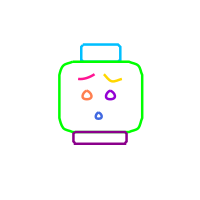

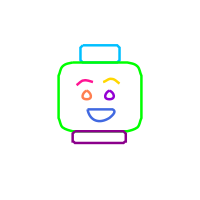

In [12]:
lego1.draw_colored(); lego2.draw_colored()

In [13]:
bird1 = load_svg("docs/frames/bird_1.svg")
bird2 = load_svg("docs/frames/bird_2.svg"); bird2.permute([1, 0, 2]);

When path orders don't match between the two frames, just manually change the order using the `permute` method. For best results, keep in mind that the the model was trained using paths ordered with the lexicographical order (top to bottom, left to right).

Colors are in this order:
- deepskyblue
- lime
- deeppink
- gold
- coral
- darkviolet
- royalblue
- darkmagenta

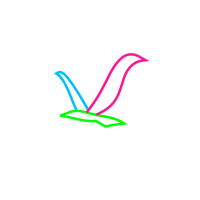

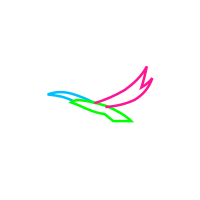

In [14]:
bird1.draw_colored(); bird2.draw_colored()

In [15]:
face1 = load_svg("docs/frames/face_1.svg"); face1.permute([1, 0, 2, 3, 4, 5]);
face2 = load_svg("docs/frames/face_2.svg"); face2.permute([5, 0, 1, 2, 3, 4]); face2[0].reverse();

Sometimes, the orientation (clockwise/counter-clockwise) of paths don't match. Fix this usng the `reverse` method.

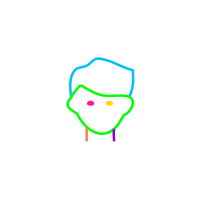

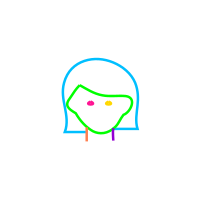

In [16]:
face1.draw_colored(); face2.draw_colored()

In [17]:
football1 = load_svg("docs/frames/football_1.svg"); football1.permute([0, 1, 4, 2, 3, 5, 6, 7]); football1[3].reverse(); football1[4].reverse();
football2 = load_svg("docs/frames/football_2.svg"); football2.permute([0, 2, 3, 5, 4, 7, 6, 1]);

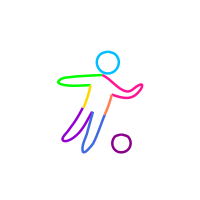

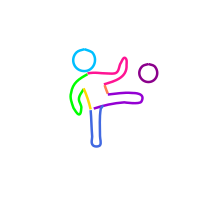

In [18]:
football1.draw_colored(); football2.draw_colored()

In [19]:
pencil1 = load_svg("docs/frames/pencil_1.svg")
pencil2 = load_svg("docs/frames/pencil_2.svg"); pencil2.permute([1, 0, 2, 3, 4, 5]);

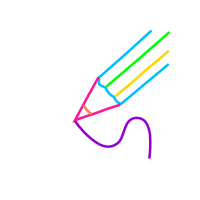

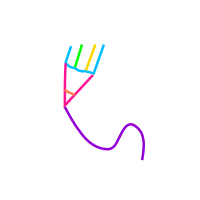

In [20]:
pencil1.draw_colored(); pencil2.draw_colored()

In [21]:
ship1 = load_svg("docs/frames/ship_1.svg"); ship1.permute([0, 1, 3, 2]);
ship2 = load_svg("docs/frames/ship_2.svg")

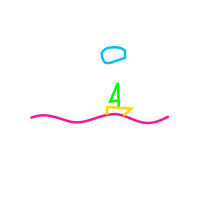

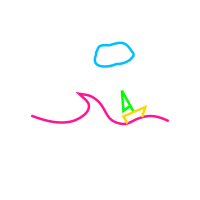

In [22]:
ship1.draw_colored(); ship2.draw_colored()

Finetune the model on those additional SVG icons for a few steps (~10-30 seconds).

In [23]:
finetune_dataset = SVGFinetuneDataset(dataset, [lego1, lego2, football1, football2, bird1, bird2, ship1, ship2, pencil1, pencil2, face1, face2],
                                      frac=1.0, nb_augmentations=750)

In [24]:
dataloader = DataLoader(finetune_dataset, batch_size=cfg.batch_size, shuffle=True, drop_last=True,
                        num_workers=cfg.loader_num_workers, collate_fn=cfg.collate_fn)

# Optimizer, lr & warmup schedulers
optimizers = cfg.make_optimizers(model)
scheduler_lrs = cfg.make_schedulers(optimizers, epoch_size=len(dataloader))
scheduler_warmups = cfg.make_warmup_schedulers(optimizers, scheduler_lrs)

loss_fns = [l.to(device) for l in cfg.make_losses()]

In [25]:
epoch = 0
for step, data in enumerate(dataloader):
    model.train()
    model_args = [data[arg].to(device) for arg in cfg.model_args]
    labels = data["label"].to(device) if "label" in data else None
    params_dict, weights_dict = cfg.get_params(step, epoch), cfg.get_weights(step, epoch)

    for i, (loss_fn, optimizer, scheduler_lr, scheduler_warmup, optimizer_start) in enumerate(
            zip(loss_fns, optimizers, scheduler_lrs, scheduler_warmups, cfg.optimizer_starts), 1):
        optimizer.zero_grad()

        output = model(*model_args, params=params_dict)
        loss_dict = loss_fn(output, labels, weights=weights_dict)

        loss_dict["loss"].backward()
        if cfg.grad_clip is not None:
            nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)

        optimizer.step()
        if scheduler_lr is not None:
            scheduler_lr.step()
        if scheduler_warmup is not None:
            scheduler_warmup.step()

        if step % 20 == 0:
            print(f"Step {step}: loss: {loss_dict['loss']}")

Step 0: loss: 20.358945846557617


In [26]:
model.eval();

Display the interpolations! 🚀

In [27]:
z_lego1, z_lego2 = encode_svg(lego1), encode_svg(lego2)
interpolate(z_lego1, z_lego2)

In [28]:
z_face1, z_face2 = encode_svg(face1), encode_svg(face2)
interpolate(z_face1, z_face2)

In [29]:
z_bird1, z_bird2 = encode_svg(bird1), encode_svg(bird2)
interpolate(z_bird1, z_bird2)

In [30]:
z_football1, z_football2 = encode_svg(football1), encode_svg(football2)
interpolate(z_football1, z_football2)

In [31]:
z_pencil1, z_pencil2 = encode_svg(pencil1), encode_svg(pencil2)
interpolate(z_pencil1, z_pencil2)

In [32]:
z_ship1, z_ship2 = encode_svg(ship1), encode_svg(ship2)
interpolate(z_ship1, z_ship2)